In [ ]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
url = 'https://raw.githubusercontent.com/aaasatoou/bootcamp_blue_Projeto2/main/Estudo%20COVID%20-%20Insights%20e%20Previs%C3%B5es/dados/Silver/datasets/serie%20temporal%20pais/S%C3%A9ries%20Temporais%20Chile.csv'

serie_chi = pd.read_csv(url)
serie_chi.drop(['Unnamed: 0','Confirmed','Recovered','Ano'],axis=1,
               inplace=True)
serie_chi.head()


,Date,Deaths
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


In [ ]:
# Selecionando apenas os primeiros meses do dataset
serie_chi = serie_chi[0:161]

In [ ]:
serie_chi['Date'] = pd.to_datetime(serie_chi['Date'],format='%Y-%m-%d')
serie_chi.set_index('Date',inplace=True)
serie_chi

,Deaths
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-06-26,5068
2020-06-27,5347
2020-06-28,5509


In [ ]:
treino = serie_chi[0:131]
teste = serie_chi[131:161]


In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 5, 1)
d = 1
q = range(0, 5, 1)
P = range(0, 5, 1)
D = 1
Q = range(0, 5, 1)
s = 2
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

625


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['Deaths'])
result_df.head()

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(2, 0, 0, 1)",639.908892
1,"(1, 1, 0, 1)",640.033817
2,"(3, 1, 0, 1)",640.342314
3,"(3, 1, 0, 2)",640.741495
4,"(2, 0, 1, 1)",640.746732


In [ ]:
best_model = SARIMAX(treino['Deaths'], order=(2, 1, 0), seasonal_order=(0, 1, 1, 4)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              Deaths   No. Observations:                  131
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 4)   Log Likelihood                -315.954
Date:                             Mon, 16 Jan 2023   AIC                            639.909
Time:                                     23:10:56   BIC                            651.254
Sample:                                 01-22-2020   HQIC                           644.518
                                      - 05-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6843      0.043     15.954      0.000       0.600       0.768
ar.L2          0.3099      

In [ ]:
fc = best_model.forecast(30, alpha=0.05)

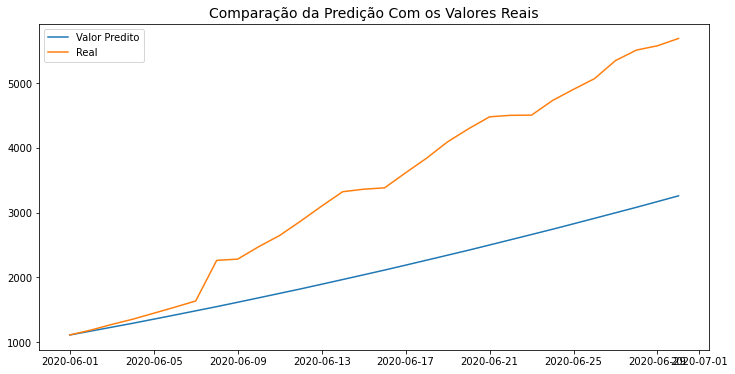

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.legend()

In [ ]:
print('MAPE:',mean_absolute_percentage_error(teste['Deaths'],fc))
print('MAE:',mean_absolute_error(teste['Deaths'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['Deaths'],fc)))

MAPE: 0.3156401118888849
MAE: 1264.2500758589908
RMSE: 1507.8260773133966
